In [1]:
import os, glob
from tqdm import tqdm_notebook as tqdm

from imageio import imwrite

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import sonnet as snt

from clic.miracle_modules import ConvDS
from clic.architectures import ClicHyperpriorVAE, ClicHyperpriorVAE2

from clic.load_data import download_process_and_load_data

tf.enable_eager_execution()

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [14]:
def process_image(image, normalize=True):
    """
    normalize will adjust all pixels of the image to lie between 0 and 1
    for every colour dimension.
    """
    
    img_tensor = tf.image.decode_image(image)

    if normalize:
        img_tensor = tf.cast(img_tensor, tf.float32)
        img_tensor /= 255.
        
    return img_tensor


def load_and_process_image(image_path, normalize=True):
    
    img_raw = tf.read_file(image_path)
    return process_image(img_raw, normalize=normalize)

In [14]:
COMPRESSION_SUBDIR = 'datasets/miracle_image_compression'

TRAIN_DATASET_URL = 'https://data.vision.ee.ethz.ch/cvl/clic/professional_train.zip'
TRAIN_DATASET_ARCHIVE = 'train.zip'

VALIDATION_DATASET_URL = 'https://data.vision.ee.ethz.ch/cvl/clic/professional_valid.zip'
VALIDATION_DATASET_ARCHIVE = 'valid.zip'

valid_path = tf.keras.utils.get_file(fname=VALIDATION_DATASET_ARCHIVE, 
                                     origin=VALIDATION_DATASET_URL, 
                                     cache_subdir=COMPRESSION_SUBDIR,
                                     extract=True)
train_path = tf.keras.utils.get_file(fname=TRAIN_DATASET_ARCHIVE, 
                                     origin=TRAIN_DATASET_URL, 
                                     cache_subdir=COMPRESSION_SUBDIR,
                                     extract=True)
valid_path, _ = os.path.splitext(valid_path)
train_path, _ = os.path.splitext(train_path)

valid_path

'/home/gf332/.keras/datasets/miracle_image_compression/valid'

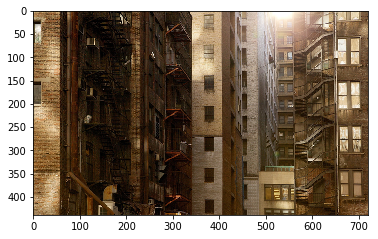

In [19]:
valid_path = "/home/gf332/.keras/datasets/miracle_image_compression/valid"

image_paths = glob.glob(valid_path + "/*.png")

test_img = load_and_process_image(image_paths[8], normalize=False)
plt.imshow(test_img)

In [ ]:
with tf.GradientTape() as tape:

    conv = snt.Conv2D(output_channels=10,
                      kernel_shape=(5, 5),
                      stride=2)

    print(test_img.shape.as_list())

    convolved = conv(test_img[tf.newaxis, ...])

    print(convolved.shape.as_list())

    conv_T = conv.transpose()

    deconvolved = conv_T(convolved)

    print(deconvolved.shape.as_list())
    
grads = tape.gradient(tf.reduce_sum(deconvolved), conv.get_all_variables())

plt.imshow(tf.nn.sigmoid(deconvolved[0, ...]))

In [9]:
paths_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
image_dataset = paths_dataset.map(lambda im: load_and_process_image(im, normalize=False), 
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
#image_dataset = image_dataset.shuffle(buffer_size=10)

dummy_dataset = image_dataset.take(4)

def create_random_crops(image, crop_coef=5, crop_size=256):
    
    w = image.shape[0]
    h = image.shape[1]
    
    num_crops = crop_coef * (w // crop_size) * (h // crop_size)
    
    crops = []
    
    for i in range(num_crops):
        crops.append(tf.image.random_crop(image, 
                                          size=(crop_size, crop_size, 3)))
        
    return crops

valid_processed_path = valid_path + "_processed/"

if not os.path.exists(valid_processed_path):
    os.mkdir(valid_processed_path)
    

    for idx, image in enumerate(dummy_dataset):

        print("Processing image {}".format(idx))
        
        crops = create_random_crops(image)

        for i, crop in tqdm(enumerate(crops), total=len(crops)):
            imwrite(valid_processed_path + "{}_{}.png".format(idx, i), crop)
            
        del crops
    
else:
    print("Data already processed!")

Instructions for updating:
Colocations handled automatically by placer.
Data already processed!


In [15]:
image_paths = glob.glob(train_path + "/*.png")
paths_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
image_dataset = paths_dataset.map(lambda im: load_and_process_image(im, normalize=False), 
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)

image_sizes = []

for image in image_dataset:
    
    image_sizes.append(image.shape)

In [16]:
len(image_sizes)

585

In [17]:
xs, ys, chans = zip(*map(lambda x: x.as_list(), image_sizes))
print("X min: {}, X max: {}, Y min: {}, Y max: {}".format(min(xs), max(xs), min(ys), max(ys)))

X min: 294, X max: 2048, Y min: 384, Y max: 2048


In [7]:
tf.contrib.layers.gdn

<function tensorflow.contrib.layers.python.layers.layers.gdn(inputs, inverse=False, beta_min=1e-06, gamma_init=0.1, reparam_offset=3.814697265625e-06, data_format='channels_last', activity_regularizer=None, trainable=True, name=None, reuse=None)>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(0.82336134, shape=(), dtype=float32)


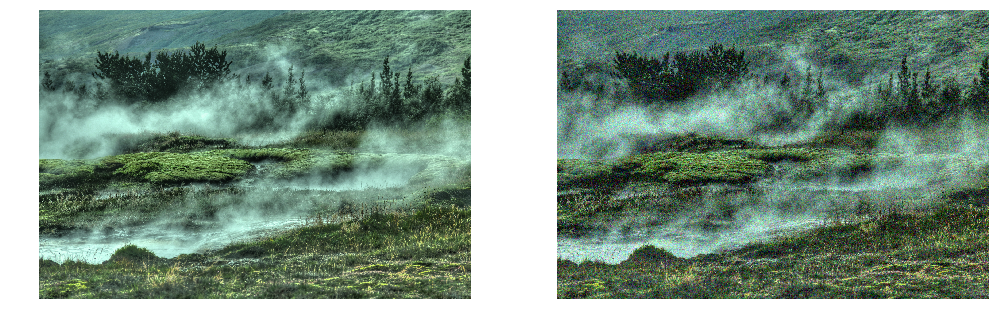

tf.Tensor(0.82336134, shape=(), dtype=float32)
tf.Tensor(-0.07383686, shape=(), dtype=float32)


In [31]:
image_dataset = paths_dataset.map(lambda im: load_and_process_image(im, normalize=True), 
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)

dummy_dataset = image_dataset.take(1)

for image in dummy_dataset:
    
    plt.figure(figsize=(17, 8))
    plt.subplot(121)
    plt.axis('off')
    plt.imshow(image)
    
    noise = tf.random.normal(image.shape, mean=0, stddev=0.1)
    
    with tf.GradientTape() as tape:
        c = tf.get_variable("const_test", initializer=tf.constant(0.9))

        noisy_image = image + noise
        #noisy_image = tf.clip_by_value(c * noisy_image, 0, 1)
        noisy_image = c * noisy_image
        
        msssim = tf.image.ssim_multiscale(noisy_image, image, 1.0)
        
        print(msssim)
        
        msssim = tf.reduce_sum(msssim)
    
    plt.subplot(122)
    plt.axis('off')
    plt.imshow(noisy_image)
    
    plt.show()

    print(msssim)
    
    print(tape.gradient(msssim, c))
    
#0.8245694

In [2]:
import numpy as np

conv_ds_test = ConvDS(output_channels=10,
                      num_convolutions=2,
                      kernel_shape=(3, 3))

conv_ds_tested = conv_ds_test(tf.convert_to_tensor(np.zeros((1, 20, 20, 3)), dtype=tf.float32))

deconv_us_test = conv_ds_test.transpose()

deconv_us_tested = deconv_us_test(conv_ds_tested)

final_conv = deconv_us_test.transpose()

final_conv_tested = final_conv(deconv_us_tested)

deconv_us_tested.shape.as_list()

Instructions for updating:
Colocations handled automatically by placer.


[1, 20, 20, 3]

In [3]:
chv = ClicHyperpriorVAE(latent_dist="gaussian",
                         likelihood="gaussian",
                         first_level_channels=192,
                         second_level_channels=128,
                         first_level_layers=4,
                         name="clic_hieararchical_vae")

test_ex = tf.convert_to_tensor(np.ones((1, 256, 256, 3)), dtype=tf.float32)
res = chv(test_ex)

In [4]:
latents = chv.encode(test_ex)

d = chv.decode((latents[1],), decode_level=1)

In [5]:
print(chv.log_prob)

print(chv.kl_divergence)

tf.Tensor(-279057.97, shape=(), dtype=float32)
tf.Tensor(87267.8, shape=(), dtype=float32)


In [6]:
chv2 = ClicHyperpriorVAE2(latent_dist="laplace",
                         likelihood="laplace",
                         first_level_channels=192,
                         second_level_channels=128,
                         first_level_layers=4)

test_ex = tf.convert_to_tensor(np.ones((1, 256, 256, 3)), dtype=tf.float32)
res = chv2(test_ex)

In [9]:
latents = chv2.encode(test_ex)

d = chv2.decode((latents[1],), decode_level=1)

print(chv2.log_prob)
print(chv2.kl_divergence)

latents[1].shape

tf.Tensor(-332891.88, shape=(), dtype=float32)
tf.Tensor(5022.951, shape=(), dtype=float32)


TensorShape([Dimension(1), Dimension(16), Dimension(16), Dimension(192)])

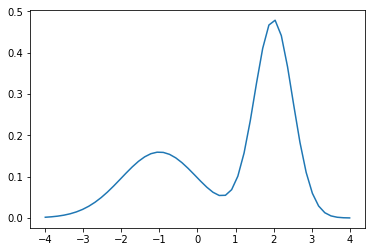

In [8]:
# MoG
mixture_coefs = [0.4, 0.6]

mog = tfd.Mixture(
    cat=tfd.Categorical(probs=mixture_coefs),
    components=[tfd.Normal(loc=-1., scale=1.),
                tfd.Normal(loc=2., scale=0.5)]
)

xs = np.linspace(-4, 4, 50)

density = mog.prob(xs)

plt.plot(xs, density)

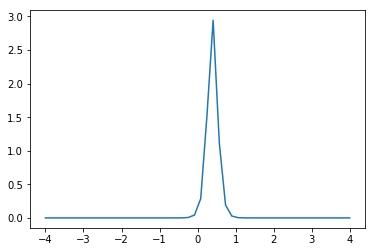

In [78]:
def non_parametric_prior(K=1, r=1):
    
    def g(x, k):
        
        a = tf.get_variable("a_{}".format(k), initializer=tf.constant(0., dtype=tf.float32), trainable=True)
        
        # Reparametrisation of a so that -1 <= a <= 1
        a = tf.tanh(a)
        
        return x + a * tf.tanh(x)
    
    
    def f(x, k, r_in, r_out):
        
        H = tf.get_variable("H_{}".format(k), shape=[r_out, r_in], trainable=True, )
        
        # Reparametrisation of H so that H >= 0
        H = tf.nn.softplus(H)
        
        b = tf.get_variable("b_{}".format(k), shape=[r_out, 1], trainable=True)
        
        return tf.matmul(H, x) + b
    
    
    def prior_cdf(x):
        
        input_shape = x.shape.as_list()[0]
        
        if K > 1:
            
            x = g(f(x, 0, input_shape, r), 0)

            for k in range(K - 1):

                x = g(f(x, k, r, r), k)

            x = tf.nn.sigmoid(f(x, K, r, 1))
            
        else:
            
            x = tf.nn.sigmoid(f(x, K, input_shape, 1))
        
        return x
    
    
    def prior_pdf(x):
        
        x_var = tf.get_variable("x_var", initializer=tf.constant(x, dtype=tf.float32))
        
        with tf.GradientTape() as tape: 
            c = prior_cdf(x_var)
            
        return tape.gradient(c, x_var)
    
    return prior_cdf, prior_pdf

c, p = non_parametric_prior(K = 4, r = 3)

c(tf.ones((2, 1)))
p(tf.ones((1, 2)))

npp_density = p(tf.convert_to_tensor(xs[None, ...], dtype=tf.float32))

plt.plot(xs, npp_density[0])

In [6]:
download_process_and_load_data(crop_coef=10, crop_size=360)

Train dataset already downloaded!
Validation dataset already downloaded!
Instructions for updating:
Colocations handled automatically by placer.
Processing Training Data!
Processing image 0 out of 585


100%|██████████| 60/60 [00:05<00:00, 12.86it/s]


Processing image 1 out of 585


100%|██████████| 150/150 [00:14<00:00,  9.83it/s]


Processing image 2 out of 585


100%|██████████| 150/150 [00:29<00:00,  5.46it/s]


Processing image 3 out of 585


100%|██████████| 150/150 [00:08<00:00, 16.99it/s]


Processing image 4 out of 585


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 5 out of 585


100%|██████████| 80/80 [00:06<00:00, 12.25it/s]


Processing image 6 out of 585


100%|██████████| 150/150 [00:07<00:00, 19.91it/s]


Processing image 7 out of 585


100%|██████████| 150/150 [00:41<00:00,  3.37it/s]


Processing image 8 out of 585


100%|██████████| 150/150 [00:09<00:00, 16.90it/s]


Processing image 9 out of 585


100%|██████████| 150/150 [00:28<00:00,  6.38it/s]


Processing image 10 out of 585


100%|██████████| 150/150 [00:35<00:00,  3.86it/s]


Processing image 11 out of 585


100%|██████████| 150/150 [00:35<00:00,  3.81it/s]


Processing image 12 out of 585


100%|██████████| 150/150 [00:07<00:00, 19.71it/s]


Processing image 13 out of 585


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 14 out of 585


100%|██████████| 80/80 [00:03<00:00, 22.42it/s]


Processing image 15 out of 585


  0%|          | 0/60 [00:00<?, ?it/s]

Processing image 16 out of 585


100%|██████████| 60/60 [00:22<00:00,  2.93it/s]


Processing image 17 out of 585


  7%|▋         | 4/60 [00:00<00:01, 34.50it/s]

Processing image 18 out of 585


100%|██████████| 60/60 [00:01<00:00, 38.88it/s]


Processing image 19 out of 585


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 20 out of 585


  5%|▌         | 2/40 [00:00<00:02, 15.43it/s]

Processing image 21 out of 585


100%|██████████| 40/40 [00:02<00:00, 15.87it/s]


Processing image 22 out of 585


  5%|▌         | 1/20 [00:00<00:03,  5.96it/s]

Processing image 23 out of 585


100%|██████████| 20/20 [00:03<00:00,  6.06it/s]


Processing image 24 out of 585


  0%|          | 0/20 [00:00<?, ?it/s]

Processing image 25 out of 585


100%|██████████| 20/20 [00:04<00:00,  4.57it/s]


Processing image 26 out of 585


  0%|          | 0/40 [00:00<?, ?it/s]

Processing image 27 out of 585


100%|██████████| 40/40 [00:03<00:00, 10.36it/s]


Processing image 28 out of 585


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 29 out of 585


  3%|▎         | 2/60 [00:00<00:03, 18.67it/s]

Processing image 30 out of 585


100%|██████████| 60/60 [00:09<00:00,  5.03it/s]


Processing image 31 out of 585


100%|██████████| 150/150 [00:09<00:00, 16.37it/s]


Processing image 32 out of 585


100%|██████████| 150/150 [00:31<00:00,  4.94it/s]


Processing image 33 out of 585


100%|██████████| 150/150 [00:28<00:00,  5.03it/s]


Processing image 34 out of 585


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 35 out of 585


100%|██████████| 80/80 [00:05<00:00, 14.93it/s]


Processing image 36 out of 585


  0%|          | 0/20 [00:00<?, ?it/s]

Processing image 37 out of 585


  0%|          | 0/90 [00:00<?, ?it/s]

Processing image 38 out of 585


100%|██████████| 90/90 [00:15<00:00,  7.68it/s]


Processing image 39 out of 585


100%|██████████| 150/150 [00:21<00:00,  6.11it/s]


Processing image 40 out of 585


100%|██████████| 150/150 [00:08<00:00, 18.09it/s]


Processing image 41 out of 585


100%|██████████| 150/150 [00:42<00:00,  3.11it/s]


Processing image 42 out of 585


100%|██████████| 150/150 [00:27<00:00,  6.05it/s]


Processing image 43 out of 585


100%|██████████| 150/150 [00:18<00:00,  6.40it/s]


Processing image 44 out of 585


  0%|          | 0/60 [00:00<?, ?it/s]

Processing image 45 out of 585


100%|██████████| 60/60 [00:04<00:00, 14.91it/s]


Processing image 46 out of 585


100%|██████████| 150/150 [00:29<00:00,  4.83it/s]


Processing image 47 out of 585


100%|██████████| 120/120 [00:34<00:00,  3.29it/s]


Processing image 48 out of 585


100%|██████████| 250/250 [00:45<00:00,  5.46it/s]


Processing image 49 out of 585


100%|██████████| 150/150 [00:07<00:00, 20.10it/s]


Processing image 50 out of 585


100%|██████████| 150/150 [00:10<00:00, 14.98it/s]


Processing image 51 out of 585


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 52 out of 585


100%|██████████| 80/80 [00:05<00:00, 16.00it/s]


Processing image 53 out of 585


100%|██████████| 200/200 [00:44<00:00,  4.49it/s]


Processing image 54 out of 585


100%|██████████| 150/150 [00:27<00:00,  5.50it/s]


Processing image 55 out of 585


100%|██████████| 150/150 [00:13<00:00, 11.50it/s]


Processing image 56 out of 585


100%|██████████| 150/150 [00:25<00:00,  8.93it/s]


Processing image 57 out of 585


100%|██████████| 150/150 [00:36<00:00,  4.49it/s]


Processing image 58 out of 585


100%|██████████| 200/200 [00:17<00:00, 11.28it/s]


Processing image 59 out of 585


100%|██████████| 150/150 [00:10<00:00, 11.89it/s]


Processing image 60 out of 585


100%|██████████| 150/150 [00:11<00:00, 11.49it/s]


Processing image 61 out of 585


100%|██████████| 150/150 [00:20<00:00,  7.12it/s]


Processing image 62 out of 585


 15%|█▌        | 3/20 [00:00<00:00, 26.30it/s]

Processing image 63 out of 585


100%|██████████| 20/20 [00:01<00:00, 18.14it/s]


Processing image 64 out of 585


100%|██████████| 150/150 [00:19<00:00,  7.70it/s]


Processing image 65 out of 585


100%|██████████| 150/150 [00:22<00:00,  5.58it/s]


Processing image 66 out of 585


  5%|▌         | 1/20 [00:00<00:02,  6.37it/s]

Processing image 67 out of 585


100%|██████████| 20/20 [00:04<00:00,  4.95it/s]


Processing image 68 out of 585


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 69 out of 585


100%|██████████| 80/80 [00:18<00:00,  4.56it/s]


Processing image 70 out of 585


100%|██████████| 150/150 [00:32<00:00,  3.20it/s]


Processing image 71 out of 585


100%|██████████| 150/150 [00:20<00:00,  7.42it/s]


Processing image 72 out of 585


100%|██████████| 150/150 [00:17<00:00,  8.68it/s]


Processing image 73 out of 585


100%|██████████| 150/150 [00:20<00:00,  7.33it/s]


Processing image 74 out of 585


100%|██████████| 150/150 [00:08<00:00, 17.39it/s]


Processing image 75 out of 585


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 76 out of 585


100%|██████████| 80/80 [00:09<00:00,  8.79it/s]


Processing image 77 out of 585


100%|██████████| 150/150 [00:07<00:00, 20.40it/s]


Processing image 78 out of 585


100%|██████████| 150/150 [00:14<00:00,  7.54it/s]


Processing image 79 out of 585


100%|██████████| 150/150 [00:18<00:00,  7.63it/s]


Processing image 80 out of 585


  0%|          | 0/20 [00:00<?, ?it/s]

Processing image 81 out of 585


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 82 out of 585


100%|██████████| 80/80 [00:13<00:00,  4.37it/s]


Processing image 83 out of 585


100%|██████████| 150/150 [00:21<00:00,  6.96it/s]


Processing image 84 out of 585


100%|██████████| 150/150 [00:37<00:00,  4.01it/s]


Processing image 85 out of 585


100%|██████████| 150/150 [00:36<00:00,  4.00it/s]


Processing image 86 out of 585


100%|██████████| 150/150 [00:15<00:00,  9.40it/s]


Processing image 87 out of 585


  0%|          | 0/20 [00:00<?, ?it/s]

Processing image 88 out of 585


100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Processing image 89 out of 585


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 90 out of 585


  0%|          | 0/20 [00:00<?, ?it/s]

Processing image 91 out of 585


  0%|          | 0/90 [00:00<?, ?it/s]

Processing image 92 out of 585


100%|██████████| 90/90 [00:09<00:00,  7.99it/s]


Processing image 93 out of 585


100%|██████████| 120/120 [00:10<00:00, 11.63it/s]


Processing image 94 out of 585


100%|██████████| 150/150 [00:08<00:00, 21.80it/s]


Processing image 95 out of 585


100%|██████████| 150/150 [00:13<00:00, 10.77it/s]


Processing image 96 out of 585


100%|██████████| 120/120 [00:08<00:00, 14.61it/s]


Processing image 97 out of 585


  5%|▌         | 1/20 [00:00<00:02,  6.60it/s]

Processing image 98 out of 585


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 99 out of 585


  0%|          | 0/60 [00:00<?, ?it/s]

Processing image 100 out of 585


100%|██████████| 60/60 [00:06<00:00,  9.82it/s]


Processing image 101 out of 585


100%|██████████| 150/150 [00:05<00:00, 25.14it/s]


Processing image 102 out of 585


100%|██████████| 150/150 [00:16<00:00,  9.04it/s]


Processing image 103 out of 585


100%|██████████| 150/150 [00:18<00:00,  6.69it/s]


Processing image 104 out of 585


100%|██████████| 200/200 [00:37<00:00,  4.44it/s]


Processing image 105 out of 585


100%|██████████| 150/150 [00:26<00:00,  6.39it/s]


Processing image 106 out of 585


100%|██████████| 120/120 [00:26<00:00,  4.56it/s]


Processing image 107 out of 585


  0%|          | 0/60 [00:00<?, ?it/s]

Processing image 108 out of 585


100%|██████████| 60/60 [00:03<00:00, 19.70it/s]


Processing image 109 out of 585


100%|██████████| 150/150 [00:16<00:00,  9.18it/s]


Processing image 110 out of 585


  0%|          | 0/60 [00:00<?, ?it/s]

Processing image 111 out of 585


  0%|          | 0/60 [00:00<?, ?it/s]

Processing image 112 out of 585


100%|██████████| 60/60 [00:05<00:00, 10.69it/s]


Processing image 113 out of 585


100%|██████████| 150/150 [00:06<00:00, 22.24it/s]


Processing image 114 out of 585


100%|██████████| 150/150 [00:15<00:00,  9.53it/s]


Processing image 115 out of 585


100%|██████████| 150/150 [00:25<00:00,  6.16it/s]


Processing image 116 out of 585


100%|██████████| 150/150 [00:52<00:00,  3.15it/s]


Processing image 117 out of 585


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 118 out of 585


100%|██████████| 80/80 [00:05<00:00, 15.28it/s]


Processing image 119 out of 585


100%|██████████| 150/150 [00:18<00:00,  8.22it/s]


Processing image 120 out of 585


100%|██████████| 150/150 [00:12<00:00, 11.83it/s]


Processing image 121 out of 585


100%|██████████| 150/150 [00:32<00:00,  2.52it/s]


Processing image 122 out of 585


 20%|██        | 4/20 [00:00<00:00, 32.87it/s]

Processing image 123 out of 585


100%|██████████| 20/20 [00:00<00:00, 28.32it/s]


Processing image 124 out of 585


100%|██████████| 150/150 [00:25<00:00,  5.89it/s]


Processing image 125 out of 585


100%|██████████| 200/200 [00:26<00:00,  6.55it/s]


Processing image 126 out of 585


  0%|          | 0/90 [00:00<?, ?it/s]

Processing image 127 out of 585


100%|██████████| 90/90 [00:08<00:00, 10.69it/s]


Processing image 128 out of 585


  5%|▌         | 3/60 [00:00<00:02, 28.40it/s]

Processing image 129 out of 585


100%|██████████| 60/60 [00:01<00:00, 32.22it/s]


Processing image 130 out of 585


100%|██████████| 150/150 [00:31<00:00,  5.03it/s]


Processing image 131 out of 585


100%|██████████| 120/120 [00:08<00:00, 14.99it/s]


Processing image 132 out of 585


100%|██████████| 150/150 [00:36<00:00,  4.15it/s]


Processing image 133 out of 585


100%|██████████| 150/150 [00:07<00:00, 19.69it/s]


Processing image 134 out of 585


100%|██████████| 150/150 [00:08<00:00, 19.82it/s]


Processing image 135 out of 585


100%|██████████| 150/150 [00:11<00:00, 13.57it/s]


Processing image 136 out of 585


 50%|█████     | 5/10 [00:00<00:00, 44.24it/s]

Processing image 137 out of 585


100%|██████████| 10/10 [00:00<00:00, 43.98it/s]


Processing image 138 out of 585


100%|██████████| 150/150 [00:12<00:00, 11.71it/s]


Processing image 139 out of 585


100%|██████████| 150/150 [00:19<00:00,  6.53it/s]


Processing image 140 out of 585


100%|██████████| 150/150 [00:07<00:00, 19.65it/s]


Processing image 141 out of 585


100%|██████████| 150/150 [00:19<00:00,  7.06it/s]


Processing image 142 out of 585


100%|██████████| 150/150 [00:43<00:00,  3.01it/s]


Processing image 143 out of 585


100%|██████████| 150/150 [00:24<00:00,  6.58it/s]


Processing image 144 out of 585


100%|██████████| 150/150 [00:29<00:00,  5.15it/s]


Processing image 145 out of 585


100%|██████████| 150/150 [00:11<00:00, 12.81it/s]


Processing image 146 out of 585


100%|██████████| 120/120 [00:13<00:00,  9.02it/s]


Processing image 147 out of 585


100%|██████████| 150/150 [00:25<00:00,  6.11it/s]


Processing image 148 out of 585


100%|██████████| 150/150 [00:34<00:00,  4.98it/s]


Processing image 149 out of 585


100%|██████████| 200/200 [00:31<00:00,  6.36it/s]


Processing image 150 out of 585


100%|██████████| 150/150 [00:31<00:00,  4.79it/s]


Processing image 151 out of 585


100%|██████████| 150/150 [00:03<00:00, 40.36it/s]


Processing image 152 out of 585


100%|██████████| 160/160 [00:46<00:00,  3.15it/s]


Processing image 153 out of 585


100%|██████████| 150/150 [00:32<00:00,  4.93it/s]


Processing image 154 out of 585


100%|██████████| 150/150 [00:44<00:00,  3.40it/s]


Processing image 155 out of 585


100%|██████████| 150/150 [00:13<00:00, 10.82it/s]


Processing image 156 out of 585


100%|██████████| 120/120 [00:08<00:00, 14.96it/s]


Processing image 157 out of 585


100%|██████████| 150/150 [00:18<00:00,  7.96it/s]


Processing image 158 out of 585


100%|██████████| 120/120 [00:23<00:00,  4.62it/s]


Processing image 159 out of 585


100%|██████████| 150/150 [00:24<00:00,  5.68it/s]


Processing image 160 out of 585


100%|██████████| 150/150 [00:17<00:00,  8.70it/s]


Processing image 161 out of 585


 15%|█▌        | 3/20 [00:00<00:00, 28.19it/s]

Processing image 162 out of 585


100%|██████████| 20/20 [00:00<00:00, 21.68it/s]


Processing image 163 out of 585


100%|██████████| 150/150 [00:11<00:00, 12.87it/s]


Processing image 164 out of 585


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 165 out of 585


  0%|          | 0/10 [00:00<?, ?it/s]

Processing image 166 out of 585


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 167 out of 585


100%|██████████| 80/80 [00:07<00:00, 10.85it/s]


Processing image 168 out of 585


100%|██████████| 150/150 [00:10<00:00, 13.66it/s]


Processing image 169 out of 585


100%|██████████| 150/150 [00:22<00:00,  5.21it/s]


Processing image 170 out of 585


100%|██████████| 150/150 [00:29<00:00,  5.46it/s]


Processing image 171 out of 585


  8%|▊         | 5/60 [00:00<00:01, 42.97it/s]

Processing image 172 out of 585


100%|██████████| 60/60 [00:01<00:00, 41.42it/s]


Processing image 173 out of 585


100%|██████████| 150/150 [00:19<00:00,  6.85it/s]


Processing image 174 out of 585


100%|██████████| 200/200 [00:23<00:00,  8.43it/s]


Processing image 175 out of 585


 25%|██▌       | 5/20 [00:00<00:00, 43.26it/s]

Processing image 176 out of 585


100%|██████████| 20/20 [00:00<00:00, 43.00it/s]


Processing image 177 out of 585


100%|██████████| 150/150 [00:18<00:00,  8.79it/s]


Processing image 178 out of 585


100%|██████████| 150/150 [00:14<00:00, 10.19it/s]


Processing image 179 out of 585


100%|██████████| 150/150 [00:16<00:00,  9.18it/s]


Processing image 180 out of 585


100%|██████████| 150/150 [00:10<00:00, 11.75it/s]


Processing image 181 out of 585


100%|██████████| 200/200 [00:23<00:00,  7.90it/s]


Processing image 182 out of 585


 20%|██        | 2/10 [00:00<00:00, 11.27it/s]

Processing image 183 out of 585


100%|██████████| 10/10 [00:00<00:00, 11.23it/s]


Processing image 184 out of 585


100%|██████████| 150/150 [00:41<00:00,  5.16it/s]


Processing image 185 out of 585


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 186 out of 585


100%|██████████| 80/80 [00:07<00:00,  9.61it/s]


Processing image 187 out of 585


100%|██████████| 200/200 [00:25<00:00,  7.92it/s]


Processing image 188 out of 585


100%|██████████| 150/150 [00:33<00:00,  5.24it/s]


Processing image 189 out of 585


100%|██████████| 200/200 [00:27<00:00,  7.23it/s]


Processing image 190 out of 585


100%|██████████| 150/150 [00:09<00:00, 15.86it/s]


Processing image 191 out of 585


100%|██████████| 150/150 [00:10<00:00, 15.65it/s]


Processing image 192 out of 585


100%|██████████| 150/150 [00:17<00:00,  8.76it/s]


Processing image 193 out of 585


100%|██████████| 150/150 [01:05<00:00,  2.16it/s]


Processing image 194 out of 585


100%|██████████| 150/150 [00:22<00:00,  6.06it/s]


Processing image 195 out of 585


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 196 out of 585


100%|██████████| 80/80 [00:13<00:00,  5.75it/s]


Processing image 197 out of 585


100%|██████████| 150/150 [00:10<00:00, 12.42it/s]


Processing image 198 out of 585


100%|██████████| 150/150 [00:11<00:00, 12.84it/s]


Processing image 199 out of 585


100%|██████████| 150/150 [00:14<00:00, 11.79it/s]


Processing image 200 out of 585


100%|██████████| 150/150 [00:37<00:00,  4.97it/s]


Processing image 201 out of 585


100%|██████████| 150/150 [00:32<00:00,  4.91it/s]


Processing image 202 out of 585


100%|██████████| 150/150 [00:05<00:00, 28.99it/s]


Processing image 203 out of 585


  5%|▌         | 1/20 [00:00<00:02,  7.14it/s]

Processing image 204 out of 585


  0%|          | 0/100 [00:00<?, ?it/s]

Processing image 205 out of 585


100%|██████████| 100/100 [00:03<00:00, 29.98it/s]


Processing image 206 out of 585


100%|██████████| 150/150 [00:43<00:00,  2.69it/s]


Processing image 207 out of 585


100%|██████████| 200/200 [00:18<00:00, 10.63it/s]


Processing image 208 out of 585


100%|██████████| 150/150 [00:30<00:00,  3.85it/s]


Processing image 209 out of 585


100%|██████████| 150/150 [00:21<00:00,  4.63it/s]


Processing image 210 out of 585


100%|██████████| 150/150 [00:38<00:00,  3.47it/s]


Processing image 211 out of 585


100%|██████████| 150/150 [00:24<00:00,  6.02it/s]


Processing image 212 out of 585


100%|██████████| 150/150 [00:06<00:00, 25.45it/s]


Processing image 213 out of 585


100%|██████████| 150/150 [00:43<00:00,  3.10it/s]


Processing image 214 out of 585


100%|██████████| 150/150 [00:05<00:00, 28.39it/s]


Processing image 215 out of 585


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 216 out of 585


100%|██████████| 80/80 [00:11<00:00,  8.65it/s]


Processing image 217 out of 585


100%|██████████| 150/150 [00:16<00:00,  9.06it/s]


Processing image 218 out of 585


100%|██████████| 150/150 [00:26<00:00,  4.47it/s]


Processing image 219 out of 585


  0%|          | 0/60 [00:00<?, ?it/s]

Processing image 220 out of 585


100%|██████████| 60/60 [00:08<00:00,  7.17it/s]


Processing image 221 out of 585


100%|██████████| 150/150 [00:47<00:00,  3.23it/s]


Processing image 222 out of 585


100%|██████████| 150/150 [00:20<00:00,  7.14it/s]


Processing image 223 out of 585


100%|██████████| 150/150 [00:06<00:00, 21.96it/s]


Processing image 224 out of 585


100%|██████████| 120/120 [00:10<00:00, 11.40it/s]


Processing image 225 out of 585


100%|██████████| 150/150 [00:16<00:00,  9.04it/s]


Processing image 226 out of 585


100%|██████████| 120/120 [00:29<00:00,  4.14it/s]


Processing image 227 out of 585


100%|██████████| 150/150 [00:07<00:00, 19.71it/s]


Processing image 228 out of 585


100%|██████████| 200/200 [00:11<00:00, 18.18it/s]
0it [00:00, ?it/s]


Processing image 229 out of 585
Processing image 230 out of 585


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 231 out of 585


100%|██████████| 80/80 [00:09<00:00,  5.11it/s]


Processing image 232 out of 585


100%|██████████| 150/150 [00:18<00:00,  7.94it/s]


Processing image 233 out of 585


100%|██████████| 150/150 [00:03<00:00, 43.76it/s]


Processing image 234 out of 585


100%|██████████| 150/150 [00:05<00:00, 26.26it/s]


Processing image 235 out of 585


100%|██████████| 150/150 [00:22<00:00,  5.06it/s]


Processing image 236 out of 585


100%|██████████| 150/150 [00:24<00:00,  4.56it/s]


Processing image 237 out of 585


100%|██████████| 150/150 [00:16<00:00,  8.16it/s]


Processing image 238 out of 585


100%|██████████| 120/120 [00:04<00:00, 29.68it/s]


Processing image 239 out of 585


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 240 out of 585


100%|██████████| 80/80 [00:06<00:00, 12.15it/s]


Processing image 241 out of 585


100%|██████████| 150/150 [00:26<00:00,  4.92it/s]


Processing image 242 out of 585


100%|██████████| 150/150 [00:36<00:00,  3.61it/s]


Processing image 243 out of 585


100%|██████████| 150/150 [00:36<00:00,  4.01it/s]


Processing image 244 out of 585


100%|██████████| 150/150 [00:05<00:00, 27.50it/s]


Processing image 245 out of 585


100%|██████████| 150/150 [00:06<00:00, 24.93it/s]


Processing image 246 out of 585


  0%|          | 0/60 [00:00<?, ?it/s]

Processing image 247 out of 585


100%|██████████| 60/60 [00:11<00:00,  5.70it/s]


Processing image 248 out of 585


100%|██████████| 150/150 [00:03<00:00, 39.12it/s]


Processing image 249 out of 585


100%|██████████| 150/150 [00:05<00:00, 27.38it/s]


Processing image 250 out of 585


100%|██████████| 150/150 [00:22<00:00,  5.49it/s]


Processing image 251 out of 585


100%|██████████| 150/150 [00:30<00:00,  4.77it/s]


Processing image 252 out of 585


100%|██████████| 150/150 [00:24<00:00,  6.51it/s]


Processing image 253 out of 585


100%|██████████| 150/150 [00:18<00:00,  7.60it/s]


Processing image 254 out of 585


100%|██████████| 150/150 [00:48<00:00,  3.31it/s]


Processing image 255 out of 585


  0%|          | 0/60 [00:00<?, ?it/s]

Processing image 256 out of 585


  0%|          | 0/20 [00:00<?, ?it/s]

Processing image 257 out of 585


100%|██████████| 20/20 [00:01<00:00, 13.42it/s]


Processing image 258 out of 585


100%|██████████| 150/150 [00:03<00:00, 43.73it/s]


Processing image 259 out of 585


100%|██████████| 150/150 [00:17<00:00,  8.62it/s]


Processing image 260 out of 585


100%|██████████| 120/120 [00:09<00:00,  8.28it/s]


Processing image 261 out of 585


100%|██████████| 150/150 [00:03<00:00, 38.36it/s]


Processing image 262 out of 585


100%|██████████| 150/150 [00:07<00:00, 19.77it/s]


Processing image 263 out of 585


100%|██████████| 150/150 [00:49<00:00,  3.59it/s]


Processing image 264 out of 585


100%|██████████| 150/150 [00:22<00:00,  6.48it/s]


Processing image 265 out of 585


100%|██████████| 150/150 [00:09<00:00, 15.77it/s]


Processing image 266 out of 585


100%|██████████| 150/150 [00:28<00:00,  5.25it/s]


Processing image 267 out of 585


100%|██████████| 150/150 [00:21<00:00,  5.89it/s]


Processing image 268 out of 585


100%|██████████| 150/150 [00:37<00:00,  4.19it/s]


Processing image 269 out of 585


100%|██████████| 150/150 [00:16<00:00,  9.08it/s]


Processing image 270 out of 585


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 271 out of 585


100%|██████████| 80/80 [00:11<00:00,  6.69it/s]


Processing image 272 out of 585


  0%|          | 0/60 [00:00<?, ?it/s]

Processing image 273 out of 585


 10%|█         | 2/20 [00:00<00:01, 15.97it/s]

Processing image 274 out of 585


100%|██████████| 20/20 [00:01<00:00, 10.30it/s]


Processing image 275 out of 585


100%|██████████| 100/100 [00:10<00:00,  9.43it/s]


Processing image 276 out of 585


  5%|▌         | 1/20 [00:00<00:02,  6.52it/s]

Processing image 277 out of 585


100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


Processing image 278 out of 585


100%|██████████| 150/150 [00:22<00:00,  6.30it/s]


Processing image 279 out of 585


  0%|          | 0/20 [00:00<?, ?it/s]

Processing image 280 out of 585


100%|██████████| 20/20 [00:04<00:00,  4.29it/s]


Processing image 281 out of 585


100%|██████████| 150/150 [00:41<00:00,  3.20it/s]


Processing image 282 out of 585


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 283 out of 585


100%|██████████| 80/80 [00:03<00:00, 20.49it/s]


Processing image 284 out of 585


100%|██████████| 150/150 [00:50<00:00,  3.58it/s]


Processing image 285 out of 585


 10%|█         | 2/20 [00:00<00:01, 16.92it/s]

Processing image 286 out of 585


100%|██████████| 20/20 [00:00<00:00, 20.38it/s]


Processing image 287 out of 585


 10%|█         | 1/10 [00:00<00:01,  7.16it/s]

Processing image 288 out of 585


100%|██████████| 10/10 [00:01<00:00,  7.69it/s]


Processing image 289 out of 585


 15%|█▌        | 3/20 [00:00<00:00, 20.61it/s]

Processing image 290 out of 585


100%|██████████| 20/20 [00:01<00:00, 18.19it/s]


Processing image 291 out of 585


100%|██████████| 150/150 [00:13<00:00, 11.18it/s]


Processing image 292 out of 585


100%|██████████| 160/160 [00:31<00:00,  4.51it/s]


Processing image 293 out of 585


100%|██████████| 150/150 [00:09<00:00, 15.97it/s]


Processing image 294 out of 585


100%|██████████| 150/150 [00:18<00:00,  8.23it/s]


Processing image 295 out of 585


100%|██████████| 150/150 [00:06<00:00, 22.38it/s]


Processing image 296 out of 585


100%|██████████| 150/150 [00:17<00:00, 11.41it/s]


Processing image 297 out of 585


100%|██████████| 150/150 [00:26<00:00,  5.84it/s]


Processing image 298 out of 585


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 299 out of 585


100%|██████████| 80/80 [00:14<00:00,  5.50it/s]


Processing image 300 out of 585


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 301 out of 585


100%|██████████| 80/80 [00:09<00:00,  8.93it/s]


Processing image 302 out of 585


100%|██████████| 150/150 [00:10<00:00, 13.97it/s]


Processing image 303 out of 585


  0%|          | 0/60 [00:00<?, ?it/s]

Processing image 304 out of 585


100%|██████████| 60/60 [00:05<00:00, 10.70it/s]


Processing image 305 out of 585


  2%|▏         | 1/60 [00:00<00:06,  9.26it/s]

Processing image 306 out of 585


100%|██████████| 60/60 [00:07<00:00,  8.37it/s]


Processing image 307 out of 585


100%|██████████| 120/120 [00:07<00:00, 15.86it/s]


Processing image 308 out of 585


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 309 out of 585


100%|██████████| 80/80 [00:13<00:00,  5.00it/s]


Processing image 310 out of 585


100%|██████████| 150/150 [00:13<00:00, 10.78it/s]


Processing image 311 out of 585


  0%|          | 0/60 [00:00<?, ?it/s]

Processing image 312 out of 585


100%|██████████| 60/60 [00:02<00:00, 26.73it/s]


Processing image 313 out of 585


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 314 out of 585


100%|██████████| 80/80 [00:02<00:00, 31.25it/s]


Processing image 315 out of 585


100%|██████████| 200/200 [00:17<00:00, 13.72it/s]


Processing image 316 out of 585


100%|██████████| 150/150 [00:23<00:00,  6.49it/s]


Processing image 317 out of 585


100%|██████████| 150/150 [00:05<00:00, 27.91it/s]


Processing image 318 out of 585


100%|██████████| 150/150 [00:37<00:00,  4.03it/s]


Processing image 319 out of 585


100%|██████████| 120/120 [00:14<00:00,  7.07it/s]


Processing image 320 out of 585


100%|██████████| 150/150 [00:09<00:00, 16.08it/s]


Processing image 321 out of 585


  0%|          | 0/20 [00:00<?, ?it/s]

Processing image 322 out of 585


100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


Processing image 323 out of 585


100%|██████████| 150/150 [00:12<00:00, 11.76it/s]


Processing image 324 out of 585


100%|██████████| 150/150 [00:06<00:00, 22.43it/s]


Processing image 325 out of 585


100%|██████████| 150/150 [00:41<00:00,  3.34it/s]


Processing image 326 out of 585


100%|██████████| 150/150 [00:16<00:00,  9.51it/s]


Processing image 327 out of 585


100%|██████████| 150/150 [00:09<00:00, 15.26it/s]


Processing image 328 out of 585


100%|██████████| 200/200 [00:05<00:00, 36.80it/s]


Processing image 329 out of 585


100%|██████████| 150/150 [00:23<00:00,  6.87it/s]


Processing image 330 out of 585


100%|██████████| 150/150 [00:28<00:00,  5.09it/s]


Processing image 331 out of 585


100%|██████████| 120/120 [00:34<00:00,  3.40it/s]


Processing image 332 out of 585


100%|██████████| 150/150 [00:48<00:00,  2.63it/s]


Processing image 333 out of 585


100%|██████████| 150/150 [00:12<00:00, 12.34it/s]


Processing image 334 out of 585


100%|██████████| 150/150 [00:35<00:00,  5.07it/s]


Processing image 335 out of 585


100%|██████████| 150/150 [00:30<00:00,  5.00it/s]


Processing image 336 out of 585


  0%|          | 0/60 [00:00<?, ?it/s]

Processing image 337 out of 585


100%|██████████| 60/60 [00:05<00:00, 11.73it/s]


Processing image 338 out of 585


100%|██████████| 150/150 [00:15<00:00, 10.54it/s]


Processing image 339 out of 585


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 340 out of 585


100%|██████████| 80/80 [00:06<00:00, 12.48it/s]


Processing image 341 out of 585


100%|██████████| 150/150 [00:18<00:00,  8.20it/s]


Processing image 342 out of 585


100%|██████████| 150/150 [00:04<00:00, 31.84it/s]


Processing image 343 out of 585


  0%|          | 0/20 [00:00<?, ?it/s]

Processing image 344 out of 585


100%|██████████| 20/20 [00:04<00:00,  4.67it/s]


Processing image 345 out of 585


100%|██████████| 150/150 [00:38<00:00,  4.18it/s]


Processing image 346 out of 585


100%|██████████| 150/150 [00:49<00:00,  2.96it/s]


Processing image 347 out of 585


100%|██████████| 120/120 [00:08<00:00, 14.43it/s]


Processing image 348 out of 585


 15%|█▌        | 3/20 [00:00<00:00, 17.90it/s]

Processing image 349 out of 585


100%|██████████| 20/20 [00:01<00:00,  9.39it/s]


Processing image 350 out of 585


100%|██████████| 150/150 [00:06<00:00, 25.54it/s]


Processing image 351 out of 585


100%|██████████| 150/150 [00:20<00:00,  6.05it/s]


Processing image 352 out of 585


100%|██████████| 150/150 [00:10<00:00, 14.12it/s]


Processing image 353 out of 585


100%|██████████| 150/150 [00:16<00:00,  8.83it/s]


Processing image 354 out of 585


100%|██████████| 250/250 [00:52<00:00,  5.03it/s]


Processing image 355 out of 585


100%|██████████| 150/150 [00:05<00:00, 27.10it/s]


Processing image 356 out of 585


100%|██████████| 150/150 [00:07<00:00, 19.62it/s]


Processing image 357 out of 585


100%|██████████| 150/150 [00:27<00:00,  6.24it/s]


Processing image 358 out of 585


100%|██████████| 150/150 [00:26<00:00,  5.19it/s]


Processing image 359 out of 585


100%|██████████| 150/150 [00:36<00:00,  5.35it/s]


Processing image 360 out of 585


100%|██████████| 150/150 [00:45<00:00,  3.57it/s]


Processing image 361 out of 585


100%|██████████| 150/150 [00:18<00:00,  7.56it/s]


Processing image 362 out of 585


100%|██████████| 150/150 [00:27<00:00,  5.41it/s]


Processing image 363 out of 585


100%|██████████| 150/150 [00:49<00:00,  3.23it/s]


Processing image 364 out of 585


100%|██████████| 150/150 [00:25<00:00,  4.18it/s]


Processing image 365 out of 585


100%|██████████| 150/150 [00:12<00:00, 12.13it/s]


Processing image 366 out of 585


  5%|▌         | 1/20 [00:00<00:02,  7.36it/s]

Processing image 367 out of 585


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 368 out of 585


100%|██████████| 80/80 [00:02<00:00, 36.31it/s]


Processing image 369 out of 585


100%|██████████| 150/150 [00:03<00:00, 42.25it/s]


Processing image 370 out of 585


100%|██████████| 150/150 [00:13<00:00, 10.84it/s]


Processing image 371 out of 585


100%|██████████| 150/150 [00:13<00:00, 11.48it/s]


Processing image 372 out of 585


100%|██████████| 120/120 [00:08<00:00, 14.95it/s]


Processing image 373 out of 585


100%|██████████| 150/150 [00:10<00:00, 15.14it/s]


Processing image 374 out of 585


100%|██████████| 150/150 [00:06<00:00, 27.22it/s]


Processing image 375 out of 585


  0%|          | 0/100 [00:00<?, ?it/s]

Processing image 376 out of 585


100%|██████████| 100/100 [00:04<00:00, 20.30it/s]


Processing image 377 out of 585


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 378 out of 585


100%|██████████| 80/80 [00:07<00:00,  8.05it/s]


Processing image 379 out of 585


  5%|▌         | 1/20 [00:00<00:02,  9.42it/s]

Processing image 380 out of 585


100%|██████████| 20/20 [00:01<00:00, 13.73it/s]


Processing image 381 out of 585


100%|██████████| 150/150 [00:12<00:00,  9.92it/s]


Processing image 382 out of 585


100%|██████████| 150/150 [00:25<00:00,  5.62it/s]


Processing image 383 out of 585


100%|██████████| 150/150 [00:19<00:00,  7.46it/s]


Processing image 384 out of 585


100%|██████████| 150/150 [00:12<00:00, 11.90it/s]


Processing image 385 out of 585


100%|██████████| 150/150 [00:44<00:00,  3.41it/s]


Processing image 386 out of 585


100%|██████████| 150/150 [00:34<00:00,  3.97it/s]


Processing image 387 out of 585


100%|██████████| 150/150 [00:20<00:00,  7.32it/s]


Processing image 388 out of 585


  0%|          | 0/60 [00:00<?, ?it/s]

Processing image 389 out of 585


100%|██████████| 60/60 [00:01<00:00, 30.72it/s]


Processing image 390 out of 585


  0%|          | 0/60 [00:00<?, ?it/s]

Processing image 391 out of 585


100%|██████████| 60/60 [00:02<00:00, 20.46it/s]


Processing image 392 out of 585


100%|██████████| 150/150 [00:10<00:00, 15.90it/s]


Processing image 393 out of 585


100%|██████████| 150/150 [00:05<00:00, 28.49it/s]


Processing image 394 out of 585


100%|██████████| 150/150 [01:01<00:00,  2.25it/s]


Processing image 395 out of 585


100%|██████████| 150/150 [00:16<00:00,  9.01it/s]


Processing image 396 out of 585


100%|██████████| 150/150 [00:27<00:00,  5.23it/s]


Processing image 397 out of 585


100%|██████████| 150/150 [00:04<00:00, 31.07it/s]


Processing image 398 out of 585


100%|██████████| 150/150 [00:23<00:00,  6.43it/s]


Processing image 399 out of 585


100%|██████████| 150/150 [00:16<00:00,  9.20it/s]


Processing image 400 out of 585


100%|██████████| 120/120 [00:06<00:00, 19.29it/s]


Processing image 401 out of 585


100%|██████████| 120/120 [00:22<00:00,  5.32it/s]


Processing image 402 out of 585


100%|██████████| 150/150 [00:25<00:00,  5.62it/s]


Processing image 403 out of 585


100%|██████████| 150/150 [00:16<00:00,  8.38it/s]


Processing image 404 out of 585


100%|██████████| 150/150 [00:08<00:00, 17.83it/s]


Processing image 405 out of 585


100%|██████████| 150/150 [00:36<00:00,  4.09it/s]


Processing image 406 out of 585


100%|██████████| 150/150 [00:09<00:00, 15.65it/s]


Processing image 407 out of 585


100%|██████████| 120/120 [00:13<00:00,  8.60it/s]


Processing image 408 out of 585


100%|██████████| 150/150 [00:19<00:00,  9.43it/s]


Processing image 409 out of 585


100%|██████████| 150/150 [00:31<00:00,  4.51it/s]


Processing image 410 out of 585


100%|██████████| 150/150 [00:22<00:00,  6.75it/s]


Processing image 411 out of 585


100%|██████████| 150/150 [00:10<00:00, 14.61it/s]


Processing image 412 out of 585


100%|██████████| 200/200 [00:26<00:00, 11.03it/s]


Processing image 413 out of 585


  5%|▌         | 1/20 [00:00<00:02,  9.46it/s]

Processing image 414 out of 585


100%|██████████| 20/20 [00:01<00:00, 11.93it/s]


Processing image 415 out of 585


100%|██████████| 150/150 [00:39<00:00,  4.73it/s]


Processing image 416 out of 585


100%|██████████| 150/150 [00:24<00:00,  6.12it/s]


Processing image 417 out of 585


100%|██████████| 150/150 [00:25<00:00,  4.36it/s]


Processing image 418 out of 585


100%|██████████| 200/200 [00:07<00:00, 26.02it/s]


Processing image 419 out of 585


 10%|█         | 1/10 [00:00<00:01,  6.66it/s]

Processing image 420 out of 585


100%|██████████| 10/10 [00:01<00:00,  7.09it/s]


Processing image 421 out of 585


100%|██████████| 150/150 [00:22<00:00,  6.20it/s]


Processing image 422 out of 585


100%|██████████| 150/150 [00:21<00:00,  7.08it/s]


Processing image 423 out of 585


100%|██████████| 150/150 [00:17<00:00,  8.10it/s]


Processing image 424 out of 585


100%|██████████| 120/120 [00:07<00:00, 15.19it/s]


Processing image 425 out of 585


100%|██████████| 200/200 [00:09<00:00, 21.21it/s]


Processing image 426 out of 585


100%|██████████| 150/150 [00:05<00:00, 25.82it/s]


Processing image 427 out of 585


100%|██████████| 150/150 [00:23<00:00,  6.26it/s]


Processing image 428 out of 585


  0%|          | 0/60 [00:00<?, ?it/s]

Processing image 429 out of 585


100%|██████████| 60/60 [00:10<00:00,  4.58it/s]


Processing image 430 out of 585


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 431 out of 585


100%|██████████| 80/80 [00:02<00:00, 38.04it/s]


Processing image 432 out of 585


100%|██████████| 150/150 [00:09<00:00, 16.56it/s]


Processing image 433 out of 585


100%|██████████| 150/150 [00:03<00:00, 47.79it/s]


Processing image 434 out of 585


 10%|█         | 2/20 [00:00<00:01, 13.64it/s]

Processing image 435 out of 585


100%|██████████| 20/20 [00:01<00:00, 13.29it/s]


Processing image 436 out of 585


100%|██████████| 150/150 [00:30<00:00,  4.95it/s]


Processing image 437 out of 585


  0%|          | 0/60 [00:00<?, ?it/s]

Processing image 438 out of 585


100%|██████████| 60/60 [00:06<00:00,  9.18it/s]


Processing image 439 out of 585


100%|██████████| 150/150 [00:42<00:00,  2.60it/s]


Processing image 440 out of 585


100%|██████████| 200/200 [00:36<00:00,  5.64it/s]


Processing image 441 out of 585


100%|██████████| 150/150 [00:28<00:00,  4.84it/s]


Processing image 442 out of 585


100%|██████████| 150/150 [00:18<00:00,  7.23it/s]


Processing image 443 out of 585


100%|██████████| 150/150 [00:16<00:00, 10.36it/s]


Processing image 444 out of 585


  0%|          | 0/40 [00:00<?, ?it/s]

Processing image 445 out of 585


100%|██████████| 40/40 [00:07<00:00,  5.24it/s]


Processing image 446 out of 585


100%|██████████| 150/150 [00:11<00:00, 13.20it/s]


Processing image 447 out of 585


  0%|          | 0/60 [00:00<?, ?it/s]

Processing image 448 out of 585


100%|██████████| 60/60 [00:04<00:00, 12.68it/s]


Processing image 449 out of 585


100%|██████████| 200/200 [00:13<00:00, 13.20it/s]


Processing image 450 out of 585


  0%|          | 0/40 [00:00<?, ?it/s]

Processing image 451 out of 585


100%|██████████| 40/40 [00:04<00:00,  8.34it/s]


Processing image 452 out of 585


100%|██████████| 150/150 [00:11<00:00, 13.06it/s]


Processing image 453 out of 585


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 454 out of 585


100%|██████████| 80/80 [00:01<00:00, 43.87it/s]


Processing image 455 out of 585


100%|██████████| 150/150 [00:17<00:00,  6.55it/s]


Processing image 456 out of 585


100%|██████████| 150/150 [00:21<00:00,  5.19it/s]


Processing image 457 out of 585


100%|██████████| 150/150 [00:10<00:00, 14.46it/s]


Processing image 458 out of 585


100%|██████████| 150/150 [00:07<00:00, 21.76it/s]


Processing image 459 out of 585


100%|██████████| 150/150 [00:34<00:00,  5.26it/s]


Processing image 460 out of 585


100%|██████████| 150/150 [00:24<00:00,  6.02it/s]


Processing image 461 out of 585


100%|██████████| 150/150 [00:09<00:00, 16.43it/s]


Processing image 462 out of 585


100%|██████████| 150/150 [00:16<00:00,  8.97it/s]


Processing image 463 out of 585


100%|██████████| 150/150 [00:20<00:00,  7.20it/s]


Processing image 464 out of 585


100%|██████████| 150/150 [00:36<00:00,  4.10it/s]


Processing image 465 out of 585


100%|██████████| 150/150 [00:11<00:00, 12.71it/s]


Processing image 466 out of 585


100%|██████████| 150/150 [00:11<00:00, 13.25it/s]


Processing image 467 out of 585


100%|██████████| 150/150 [00:30<00:00,  4.91it/s]


Processing image 468 out of 585


100%|██████████| 150/150 [00:27<00:00,  5.37it/s]


Processing image 469 out of 585


  0%|          | 0/60 [00:00<?, ?it/s]

Processing image 470 out of 585


100%|██████████| 60/60 [00:06<00:00,  9.59it/s]


Processing image 471 out of 585


100%|██████████| 150/150 [00:46<00:00,  4.05it/s]


Processing image 472 out of 585


100%|██████████| 150/150 [00:33<00:00,  4.15it/s]


Processing image 473 out of 585


100%|██████████| 150/150 [00:18<00:00,  8.28it/s]


Processing image 474 out of 585


100%|██████████| 150/150 [00:07<00:00, 19.82it/s]


Processing image 475 out of 585


100%|██████████| 100/100 [00:08<00:00, 12.32it/s]
0it [00:00, ?it/s]
  7%|▋         | 4/60 [00:00<00:01, 37.64it/s]

Processing image 476 out of 585
Processing image 477 out of 585


100%|██████████| 60/60 [00:01<00:00, 34.53it/s]


Processing image 478 out of 585


100%|██████████| 200/200 [00:35<00:00,  5.50it/s]


Processing image 479 out of 585


100%|██████████| 150/150 [00:26<00:00,  5.75it/s]


Processing image 480 out of 585


100%|██████████| 150/150 [00:12<00:00, 11.69it/s]


Processing image 481 out of 585


100%|██████████| 150/150 [00:11<00:00, 11.26it/s]


Processing image 482 out of 585


100%|██████████| 150/150 [00:14<00:00,  8.71it/s]


Processing image 483 out of 585


100%|██████████| 120/120 [00:40<00:00,  2.81it/s]


Processing image 484 out of 585


100%|██████████| 150/150 [00:13<00:00, 11.16it/s]


Processing image 485 out of 585


  7%|▋         | 4/60 [00:00<00:01, 35.27it/s]

Processing image 486 out of 585


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 487 out of 585


100%|██████████| 80/80 [00:11<00:00,  8.85it/s]


Processing image 488 out of 585


100%|██████████| 150/150 [00:10<00:00, 14.96it/s]


Processing image 489 out of 585


100%|██████████| 150/150 [00:26<00:00,  2.95it/s]


Processing image 490 out of 585


100%|██████████| 120/120 [00:06<00:00, 18.60it/s]


Processing image 491 out of 585


  0%|          | 0/60 [00:00<?, ?it/s]

Processing image 492 out of 585


100%|██████████| 60/60 [00:08<00:00,  5.81it/s]


Processing image 493 out of 585


100%|██████████| 150/150 [00:05<00:00, 26.68it/s]


Processing image 494 out of 585


100%|██████████| 150/150 [00:11<00:00, 12.94it/s]


Processing image 495 out of 585


100%|██████████| 200/200 [00:20<00:00,  9.81it/s]


Processing image 496 out of 585


  0%|          | 0/20 [00:00<?, ?it/s]

Processing image 497 out of 585


100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


Processing image 498 out of 585


100%|██████████| 150/150 [00:24<00:00,  6.04it/s]


Processing image 499 out of 585


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 500 out of 585


100%|██████████| 80/80 [00:13<00:00,  5.82it/s]


Processing image 501 out of 585


100%|██████████| 200/200 [00:28<00:00,  5.99it/s]


Processing image 502 out of 585


100%|██████████| 150/150 [00:19<00:00,  7.52it/s]


Processing image 503 out of 585


100%|██████████| 150/150 [00:12<00:00, 10.74it/s]


Processing image 504 out of 585


100%|██████████| 120/120 [00:17<00:00,  6.68it/s]


Processing image 505 out of 585


100%|██████████| 120/120 [00:21<00:00,  5.58it/s]


Processing image 506 out of 585


100%|██████████| 150/150 [00:20<00:00,  7.18it/s]


Processing image 507 out of 585


100%|██████████| 150/150 [00:05<00:00, 26.90it/s]


Processing image 508 out of 585


  5%|▌         | 1/20 [00:00<00:03,  5.83it/s]

Processing image 509 out of 585


100%|██████████| 20/20 [00:03<00:00,  6.30it/s]


Processing image 510 out of 585


  0%|          | 0/100 [00:00<?, ?it/s]

Processing image 511 out of 585


  0%|          | 0/10 [00:00<?, ?it/s]

Processing image 512 out of 585


  0%|          | 0/100 [00:00<?, ?it/s]

Processing image 513 out of 585


100%|██████████| 100/100 [00:02<00:00, 34.62it/s]


Processing image 514 out of 585


  0%|          | 0/60 [00:00<?, ?it/s]

Processing image 515 out of 585


100%|██████████| 60/60 [00:14<00:00,  3.74it/s]


Processing image 516 out of 585


100%|██████████| 150/150 [00:15<00:00,  9.45it/s]


Processing image 517 out of 585


  0%|          | 0/60 [00:00<?, ?it/s]

Processing image 518 out of 585


100%|██████████| 60/60 [00:05<00:00,  9.94it/s]


Processing image 519 out of 585


100%|██████████| 150/150 [00:12<00:00, 11.70it/s]


Processing image 520 out of 585


100%|██████████| 150/150 [00:08<00:00, 18.85it/s]


Processing image 521 out of 585


100%|██████████| 150/150 [00:16<00:00,  9.06it/s]


Processing image 522 out of 585


100%|██████████| 150/150 [00:14<00:00, 10.58it/s]


Processing image 523 out of 585


  0%|          | 0/60 [00:00<?, ?it/s]

Processing image 524 out of 585


100%|██████████| 60/60 [00:03<00:00, 15.34it/s]


Processing image 525 out of 585


  0%|          | 0/60 [00:00<?, ?it/s]

Processing image 526 out of 585


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 527 out of 585


100%|██████████| 80/80 [00:06<00:00, 11.62it/s]


Processing image 528 out of 585


100%|██████████| 150/150 [00:23<00:00,  4.36it/s]


Processing image 529 out of 585


100%|██████████| 150/150 [00:23<00:00,  4.79it/s]


Processing image 530 out of 585


100%|██████████| 200/200 [00:05<00:00, 36.93it/s]


Processing image 531 out of 585


 10%|█         | 1/10 [00:00<00:01,  5.69it/s]

Processing image 532 out of 585


100%|██████████| 10/10 [00:01<00:00,  4.81it/s]


Processing image 533 out of 585


100%|██████████| 150/150 [00:10<00:00, 13.62it/s]


Processing image 534 out of 585


  0%|          | 0/60 [00:00<?, ?it/s]

Processing image 535 out of 585


100%|██████████| 60/60 [00:06<00:00, 10.47it/s]


Processing image 536 out of 585


  0%|          | 0/60 [00:00<?, ?it/s]

Processing image 537 out of 585


100%|██████████| 60/60 [00:04<00:00, 12.11it/s]


Processing image 538 out of 585


100%|██████████| 150/150 [00:14<00:00, 10.77it/s]


Processing image 539 out of 585


100%|██████████| 150/150 [00:27<00:00,  5.40it/s]


Processing image 540 out of 585


  0%|          | 0/60 [00:00<?, ?it/s]

Processing image 541 out of 585


100%|██████████| 60/60 [00:16<00:00,  2.98it/s]


Processing image 542 out of 585


100%|██████████| 100/100 [00:24<00:00,  3.75it/s]


Processing image 543 out of 585


100%|██████████| 150/150 [00:11<00:00, 12.80it/s]


Processing image 544 out of 585


100%|██████████| 120/120 [00:36<00:00,  2.58it/s]


Processing image 545 out of 585


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 546 out of 585


100%|██████████| 80/80 [00:10<00:00,  7.06it/s]


Processing image 547 out of 585


  0%|          | 0/10 [00:00<?, ?it/s]

Processing image 548 out of 585


100%|██████████| 10/10 [00:02<00:00,  4.44it/s]


Processing image 549 out of 585


100%|██████████| 150/150 [00:09<00:00, 14.41it/s]


Processing image 550 out of 585


100%|██████████| 150/150 [00:19<00:00,  5.67it/s]


Processing image 551 out of 585


100%|██████████| 150/150 [00:09<00:00, 14.08it/s]


Processing image 552 out of 585


100%|██████████| 120/120 [00:04<00:00, 25.79it/s]


Processing image 553 out of 585


100%|██████████| 150/150 [00:10<00:00, 11.04it/s]


Processing image 554 out of 585


100%|██████████| 150/150 [00:18<00:00,  5.36it/s]


Processing image 555 out of 585


100%|██████████| 150/150 [00:34<00:00,  3.87it/s]


Processing image 556 out of 585


100%|██████████| 150/150 [00:15<00:00,  7.04it/s]


Processing image 557 out of 585


100%|██████████| 150/150 [00:16<00:00,  9.23it/s]


Processing image 558 out of 585


100%|██████████| 150/150 [00:25<00:00,  5.37it/s]


Processing image 559 out of 585


 10%|█         | 2/20 [00:00<00:01, 16.08it/s]

Processing image 560 out of 585


100%|██████████| 20/20 [00:01<00:00, 12.94it/s]


Processing image 561 out of 585


100%|██████████| 150/150 [00:17<00:00,  8.82it/s]


Processing image 562 out of 585


100%|██████████| 150/150 [00:44<00:00,  2.42it/s]


Processing image 563 out of 585


100%|██████████| 200/200 [00:57<00:00,  4.10it/s]


Processing image 564 out of 585


100%|██████████| 150/150 [00:13<00:00, 11.15it/s]


Processing image 565 out of 585


  0%|          | 0/40 [00:00<?, ?it/s]

Processing image 566 out of 585


100%|██████████| 40/40 [00:10<00:00,  3.72it/s]


Processing image 567 out of 585


  0%|          | 0/60 [00:00<?, ?it/s]

Processing image 568 out of 585


100%|██████████| 60/60 [00:05<00:00, 10.54it/s]


Processing image 569 out of 585


100%|██████████| 150/150 [00:23<00:00,  5.85it/s]


Processing image 570 out of 585


100%|██████████| 120/120 [00:05<00:00, 22.81it/s]


Processing image 571 out of 585


100%|██████████| 150/150 [00:31<00:00,  5.86it/s]


Processing image 572 out of 585


100%|██████████| 150/150 [00:54<00:00,  2.75it/s]


Processing image 573 out of 585


  0%|          | 0/100 [00:00<?, ?it/s]

Processing image 574 out of 585


100%|██████████| 100/100 [00:12<00:00,  9.04it/s]


Processing image 575 out of 585


 10%|█         | 1/10 [00:00<00:01,  6.57it/s]

Processing image 576 out of 585


100%|██████████| 10/10 [00:01<00:00,  6.76it/s]


Processing image 577 out of 585


100%|██████████| 150/150 [00:06<00:00, 22.33it/s]


Processing image 578 out of 585


100%|██████████| 150/150 [00:08<00:00, 17.63it/s]


Processing image 579 out of 585


100%|██████████| 150/150 [00:39<00:00,  2.93it/s]


Processing image 580 out of 585


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 581 out of 585


100%|██████████| 80/80 [00:07<00:00, 12.58it/s]


Processing image 582 out of 585


100%|██████████| 150/150 [00:10<00:00, 13.97it/s]


Processing image 583 out of 585


100%|██████████| 150/150 [00:29<00:00,  4.46it/s]


Processing image 584 out of 585


100%|██████████| 150/150 [00:22<00:00,  6.63it/s]


Processing Validation Data!
Processing image 0 out of 41


100%|██████████| 120/120 [00:07<00:00, 14.47it/s]


Processing image 1 out of 41


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 2 out of 41


100%|██████████| 80/80 [00:07<00:00, 10.74it/s]


Processing image 3 out of 41


100%|██████████| 150/150 [00:07<00:00, 15.34it/s]


Processing image 4 out of 41


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 5 out of 41


100%|██████████| 80/80 [00:03<00:00, 23.62it/s]


Processing image 6 out of 41


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 7 out of 41


 20%|██        | 4/20 [00:00<00:00, 30.54it/s]

Processing image 8 out of 41


  0%|          | 0/60 [00:00<?, ?it/s]

Processing image 9 out of 41


100%|██████████| 60/60 [00:05<00:00, 11.18it/s]


Processing image 10 out of 41


100%|██████████| 150/150 [00:42<00:00,  2.93it/s]


Processing image 11 out of 41


100%|██████████| 150/150 [00:31<00:00,  5.66it/s]


Processing image 12 out of 41


100%|██████████| 150/150 [00:14<00:00,  9.77it/s]


Processing image 13 out of 41


  0%|          | 0/20 [00:00<?, ?it/s]

Processing image 14 out of 41


100%|██████████| 20/20 [00:02<00:00,  6.99it/s]


Processing image 15 out of 41


100%|██████████| 150/150 [00:12<00:00, 11.14it/s]


Processing image 16 out of 41


100%|██████████| 150/150 [00:32<00:00,  4.64it/s]


Processing image 17 out of 41


  0%|          | 0/80 [00:00<?, ?it/s]

Processing image 18 out of 41


  0%|          | 0/10 [00:00<?, ?it/s]

Processing image 19 out of 41


100%|██████████| 10/10 [00:02<00:00,  4.48it/s]


Processing image 20 out of 41


100%|██████████| 150/150 [00:26<00:00,  4.81it/s]


Processing image 21 out of 41


100%|██████████| 150/150 [00:07<00:00, 19.31it/s]


Processing image 22 out of 41


  0%|          | 0/60 [00:00<?, ?it/s]

Processing image 23 out of 41


100%|██████████| 60/60 [00:07<00:00,  8.49it/s]


Processing image 24 out of 41


100%|██████████| 100/100 [00:16<00:00,  5.71it/s]


Processing image 25 out of 41


100%|██████████| 150/150 [00:16<00:00,  8.98it/s]


Processing image 26 out of 41


100%|██████████| 150/150 [00:21<00:00,  6.94it/s]


Processing image 27 out of 41


100%|██████████| 150/150 [00:05<00:00, 26.63it/s]


Processing image 28 out of 41


100%|██████████| 150/150 [00:08<00:00, 23.15it/s]


Processing image 29 out of 41


100%|██████████| 150/150 [00:16<00:00,  8.93it/s]


Processing image 30 out of 41


100%|██████████| 150/150 [00:19<00:00,  6.69it/s]


Processing image 31 out of 41


100%|██████████| 150/150 [00:31<00:00,  5.52it/s]


Processing image 32 out of 41


100%|██████████| 150/150 [00:47<00:00,  3.75it/s]


Processing image 33 out of 41


 25%|██▌       | 5/20 [00:00<00:00, 41.58it/s]

Processing image 34 out of 41


100%|██████████| 20/20 [00:00<00:00, 41.76it/s]


Processing image 35 out of 41


100%|██████████| 150/150 [00:22<00:00,  6.70it/s]


Processing image 36 out of 41


100%|██████████| 150/150 [00:09<00:00, 13.72it/s]


Processing image 37 out of 41


100%|██████████| 150/150 [00:13<00:00, 11.41it/s]


Processing image 38 out of 41


100%|██████████| 150/150 [00:41<00:00,  2.85it/s]


Processing image 39 out of 41


100%|██████████| 150/150 [00:14<00:00, 10.60it/s]


Processing image 40 out of 41


100%|██████████| 150/150 [00:17<00:00,  8.38it/s]


(<DatasetV1Adapter shapes: <unknown>, types: tf.float32>,
 <DatasetV1Adapter shapes: <unknown>, types: tf.float32>)

In [5]:
!ls /home/gf332/.keras/datasets/miracle_image_compression

__MACOSX  train  train.zip  valid  valid.zip


In [4]:
#!rm -rf /home/gf332/.keras/datasets/miracle_image_compression/train_processed
#!rm -rf /home/gf332/.keras/datasets/miracle_image_compression/valid_processed

In [12]:
!ls /home/gf332/.keras/datasets/miracle_image_compression/valid_processed/8_*

/home/gf332/.keras/datasets/miracle_image_compression/valid_processed/8_0.png
/home/gf332/.keras/datasets/miracle_image_compression/valid_processed/8_10.png
/home/gf332/.keras/datasets/miracle_image_compression/valid_processed/8_11.png
/home/gf332/.keras/datasets/miracle_image_compression/valid_processed/8_12.png
/home/gf332/.keras/datasets/miracle_image_compression/valid_processed/8_13.png
/home/gf332/.keras/datasets/miracle_image_compression/valid_processed/8_14.png
/home/gf332/.keras/datasets/miracle_image_compression/valid_processed/8_15.png
/home/gf332/.keras/datasets/miracle_image_compression/valid_processed/8_16.png
/home/gf332/.keras/datasets/miracle_image_compression/valid_processed/8_17.png
/home/gf332/.keras/datasets/miracle_image_compression/valid_processed/8_18.png
/home/gf332/.keras/datasets/miracle_image_compression/valid_processed/8_19.png
/home/gf332/.keras/datasets/miracle_image_compression/valid_processed/8_1.png
/home/gf332/.keras/datasets/miracle_image_compression/

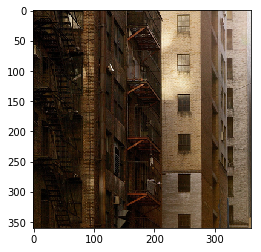

In [16]:
test_img = load_and_process_image("/home/gf332/.keras/datasets/miracle_image_compression/valid_processed/8_3.png", 
                                  normalize=False)
plt.imshow(test_img)

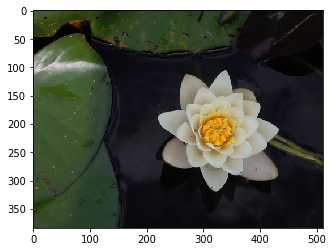

In [21]:
valid_path = "/home/gf332/.keras/datasets/miracle_image_compression/valid"

image_paths = glob.glob(valid_path + "/*.png")

test_img = load_and_process_image(image_paths[19], normalize=False)
plt.imshow(test_img)